In [1]:
!pip install --upgrade statsmodels  

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels as sm
from concurrent.futures import ThreadPoolExecutor  
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error  
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import r2_score
from scipy.stats import skew, boxcox, shapiro


# Set option to display all columns  
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)  

In [2]:
import os
print(os.listdir("../input"))

['Database MiniPONS.csv', 'Time-Cost-Quality of Hire.csv']


In [3]:
## Import dataset
data = pd.read_csv("/kaggle/input/Time-Cost-Quality of Hire.csv",delimiter=";")

In [4]:
## Overview of the dataset header
data.head(5)

,Sl. No,Fiscal Year,Quarter,Department,Job Open Date,Hire Date,Job Title,Source of Hire,Type of Hire,PerformanceScore,Sex,Yearly PayScale (Yen),Cost of Hire,Time to Hire (Days),Quality of Hire,Engagement,Ramp Up Time,Culture Fit (%)
0,1,2018,1,Production,04/01/2018,03/02/2018,Production Technician I,Job Boards,External,Fully Meets,F,744000,2625,30,41,45,95,47
1,2,2018,1,Production,05/01/2018,02/02/2018,Production Technician I,Agency,External,Fully Meets,F,744000,89280,28,41,82,95,47
2,3,2018,1,Production,04/02/2018,05/04/2018,Production Technician I,LinkedIn,External,Exceeds,F,660000,4000,60,41,26,85,48
3,4,2018,1,IT,04/02/2018,03/03/2018,Software Engineer,Agency,External,Fully Meets,F,960000,115200,27,41,28,85,48
4,5,2018,1,Production,04/02/2018,04/03/2018,Production Technician I,Career Portal,External,Fully Meets,M,660000,10000,28,41,34,93,51


## Analyse des données

In [5]:
def eda(data):
    ## Overview of dataset
    print('The total number of rows:{} and columns:{}'.format(data.shape[0],data.shape[1]))
    print(f"Variable type: {data.select_dtypes(include=['object']).shape[1]} variables object typed, "  
          f"the others are continuous (int).")  
    print("---------------------------------------------------------------------")
    ## Numerical variables description
    print(data.describe())                   
    print("---------------------------------------------------------------------")
    ## Catgorical variables description
    print(data.describe(include='object'))  
    print("---------------------------------------------------------------------")

    # Univariate analysis
    data.hist(figsize=(16,12))
    plt.tight_layout()

    ## Checking skewness
    print("Asymétrie droite")
    for i in data.select_dtypes(exclude='O'):
        if data[i].skew() > 1:
            print(i,':',data[i].skew())  
    print("---------------------------------------------------------------------")

    print("Asymétrie gauche")
    for i in data.select_dtypes(exclude='O'):
        if data[i].skew() < -1:
            print(i,':',data[i].skew())  
    print("---------------------------------------------------------------------")

    ## Unique values
    for col in data.select_dtypes(include=['object']):  
        if col != "Job Open Date" and col != "Hire Date":
            print(f'Column {col:-<50} {len(data[col].unique())} unique values')  # Print unique counts  
            print(data[col].value_counts())

    print("---------------------------------------------------------------------")

    # Setting up the plot  
    variables=['Cost of Hire','Time to Hire (Days)','Quality of Hire']
    
    # Identify numerical and categorical variables
    numerical_vars = data.select_dtypes(include=["float64", "int64"]).columns
    categorical_vars = data.select_dtypes(include=["object", "category"]).columns

    # Assuming data is your DataFrame and continuous_var and numerical_vars are defined  
    num_vars_count = len(numerical_vars)  
    num_cols = 3  # Number of columns for the subplots  
    num_rows = (num_vars_count + num_cols - 1) // num_cols  # Compute number of rows needed  
    
   ## Correlation analysis
    for col in variables:
        # Identify negative correlations with the target variable  
        negative_correlations = data[numerical_vars].corr()[col].sort_values()[data[numerical_vars].corr()[col].sort_values() < 0]  
        print(f"The below variables have a negative covariance with the target variable {col}:\n{negative_correlations}")  
            
        # Identify positive correlations with the target variable  
        positive_correlations = data[numerical_vars].corr()[col].sort_values()[data[numerical_vars].corr()[col].sort_values() > 0]  
        print(f"The below variables have the largest covariances with the target variable {col}:\n{positive_correlations}")  
        
        print("---------------------------------------------------------------------")

    # Categorical variables 
    for continuous_var in variables:
        # Create subplots  
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))  
        axes = axes.flatten()  # Flatten axes array for easy iteration  

        # Loop over numerical variables and create scatter plots  
        for idx, var in enumerate(categorical_vars):  
            # Box plot for categorical variables
            sns.boxplot(x=data[var], y=data[continuous_var], palette="Set2", ax=axes[idx])
            axes[idx].set_title(f"{continuous_var} vs {var}")
            axes[idx].set_xlabel(var)
            axes[idx].set_ylabel(continuous_var)
            axes[idx].tick_params(axis='x', rotation=45)
        
        # Hide any empty subplots if there are not enough numerical variables  
        for j in range(idx + 1, len(axes)):  
            fig.delaxes(axes[j])  
        
        plt.tight_layout()  
        plt.show()  
    print("---------------------------------------------------------------------")

    # Check if there's linear relation between the 3 dependent variables(Cost,Time,Quality)
    
    column_pairs = [
    ("Cost of Hire", "Time to Hire (Days)"),
    ("Cost of Hire", "Quality of Hire"),
    ("Time to Hire (Days)", "Quality of Hire")
    ]
    
    # Calculate the number of plots needed
    num_plots = len(column_pairs)
    
    # Set up the figure and axes
    fig, axes = plt.subplots(nrows=num_plots // 2 + (num_plots % 2), ncols=2, figsize=(12, 6))
    
    # Iterate through the column pairs and create the plots
    for i, (x_col, y_col) in enumerate(column_pairs):
        if i < num_plots:  # Check if there are enough data pairs
            row = i // 2
            col = i % 2
            sns.regplot(x=data[x_col], y=data[y_col], ax=axes[row, col])
            axes[row, col].set_xlabel(x_col)
            axes[row, col].set_ylabel(y_col)
        else:
            # Hide the unused subplot
            axes[row, col].axis('off')
    
    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

    # Add : categorical variables analysis 
    categorical_columns = [col for col in data.select_dtypes(include=["object", "category"]).columns
                           if col not in ['Job Open Date', 'Hire Date']]
    
    n_cols = 3
    n_rows = -(-len(categorical_columns) // n_cols)  

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
    axes = axes.flatten()  

    for i, col in enumerate(categorical_columns):
        sns.countplot(x=data[col], order=data[col].value_counts().index, palette="Blues_r", ax=axes[i])
        axes[i].set_title(col)
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    

The total number of rows:64 and columns:18
Variable type: 8 variables object typed, the others are continuous (int).
---------------------------------------------------------------------
          Sl. No  Fiscal Year    Quarter  Yearly PayScale (Yen)  \
count  64.000000         64.0  64.000000           6.400000e+01   
mean   32.500000       2018.0   2.703125           4.914450e+05   
std    18.618987          0.0   1.064278           2.074369e+05   
min     1.000000       2018.0   1.000000           1.680000e+05   
25%    16.750000       2018.0   2.000000           3.405000e+05   
50%    32.500000       2018.0   3.000000           4.773000e+05   
75%    48.250000       2018.0   4.000000           6.600000e+05   
max    64.000000       2018.0   4.000000           1.008000e+06   

        Cost of Hire  Time to Hire (Days)  Quality of Hire  Engagement  \
count      64.000000            64.000000        64.000000   64.000000   
mean    18032.500000            35.312500        79.437500   

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


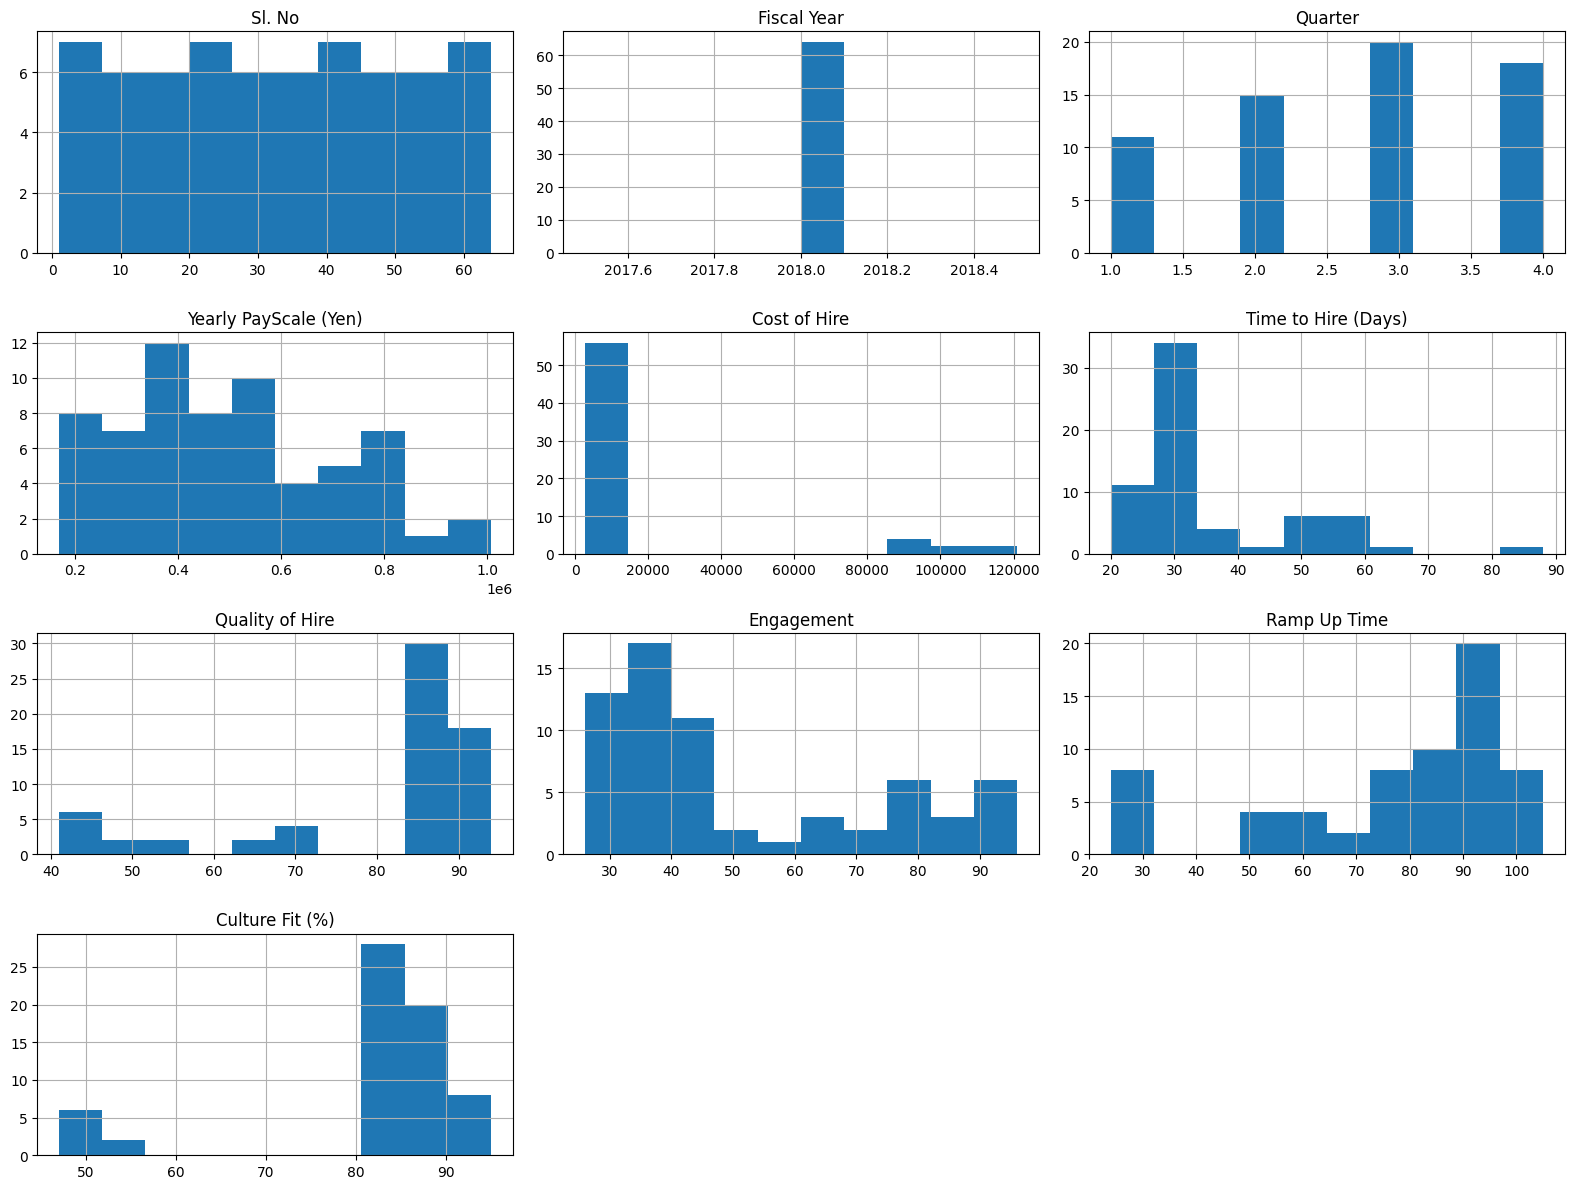

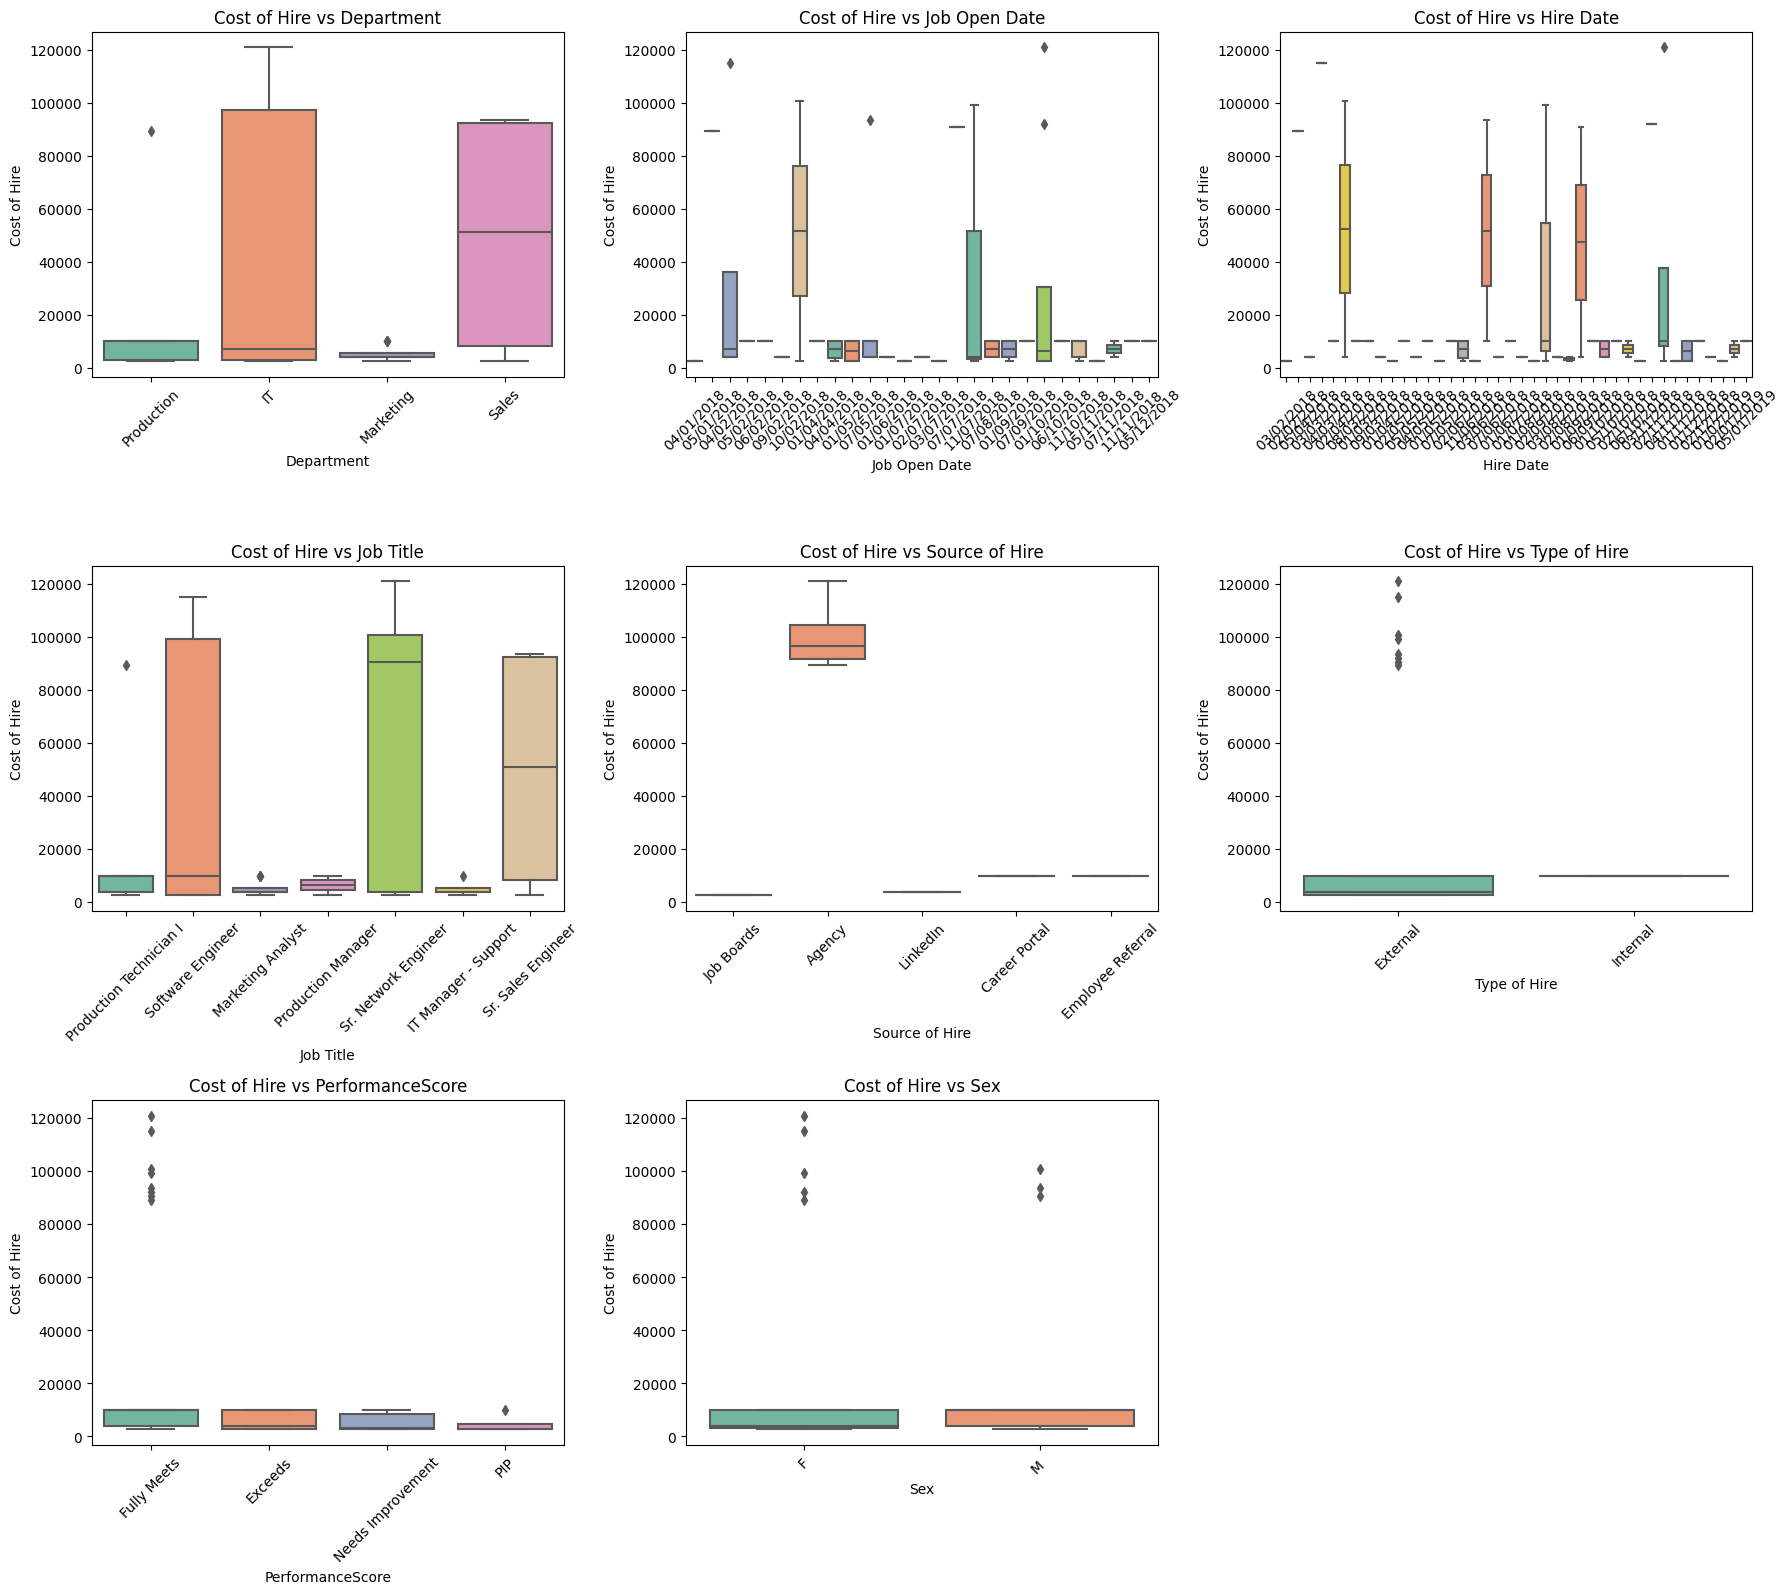

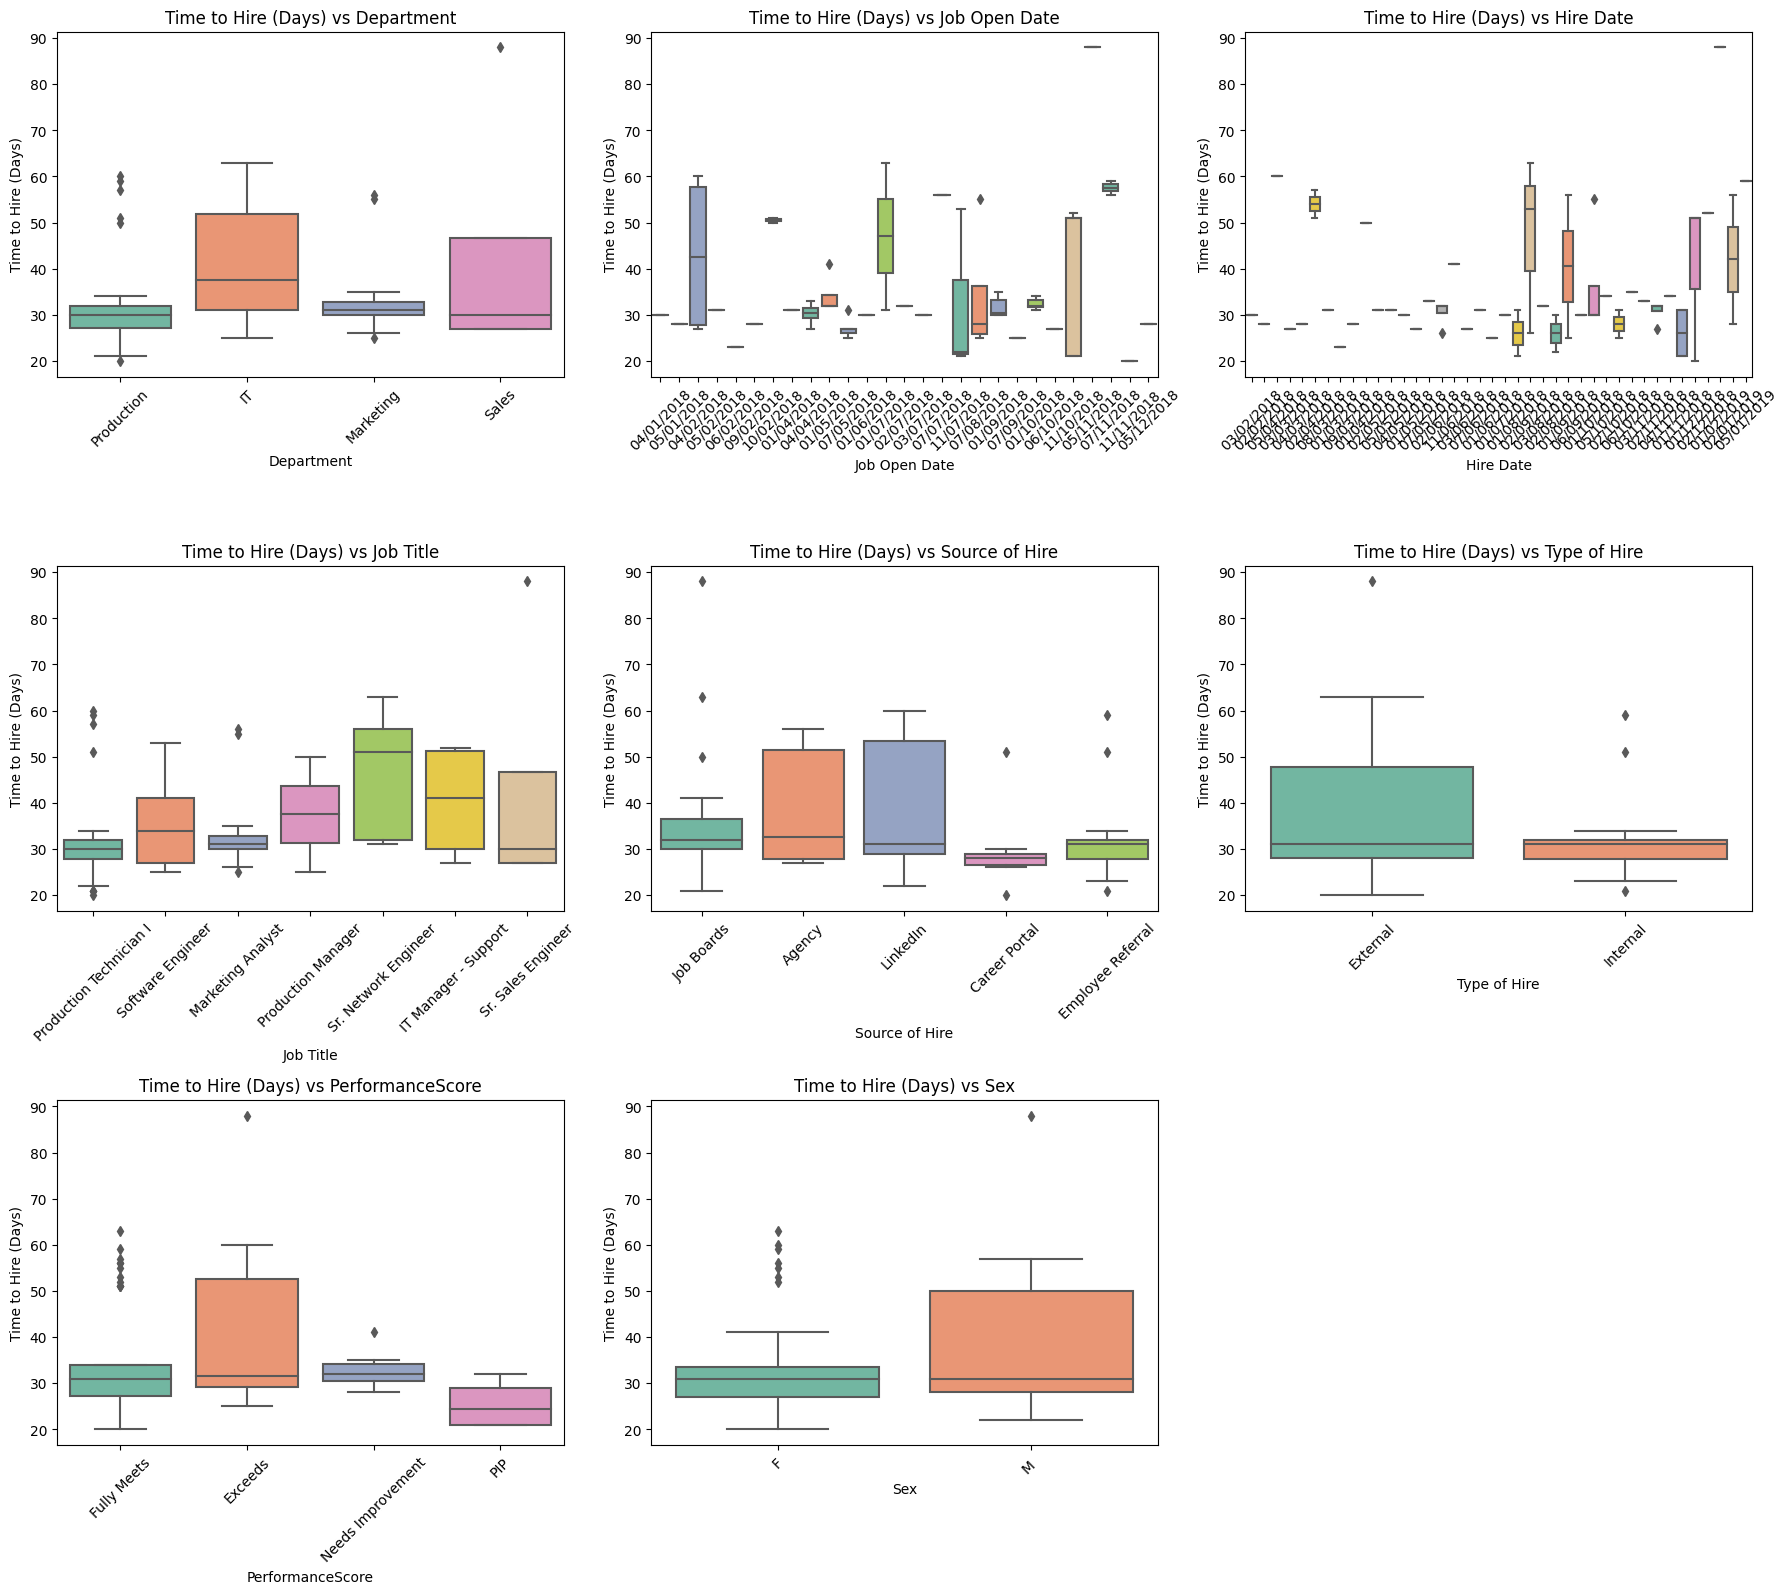

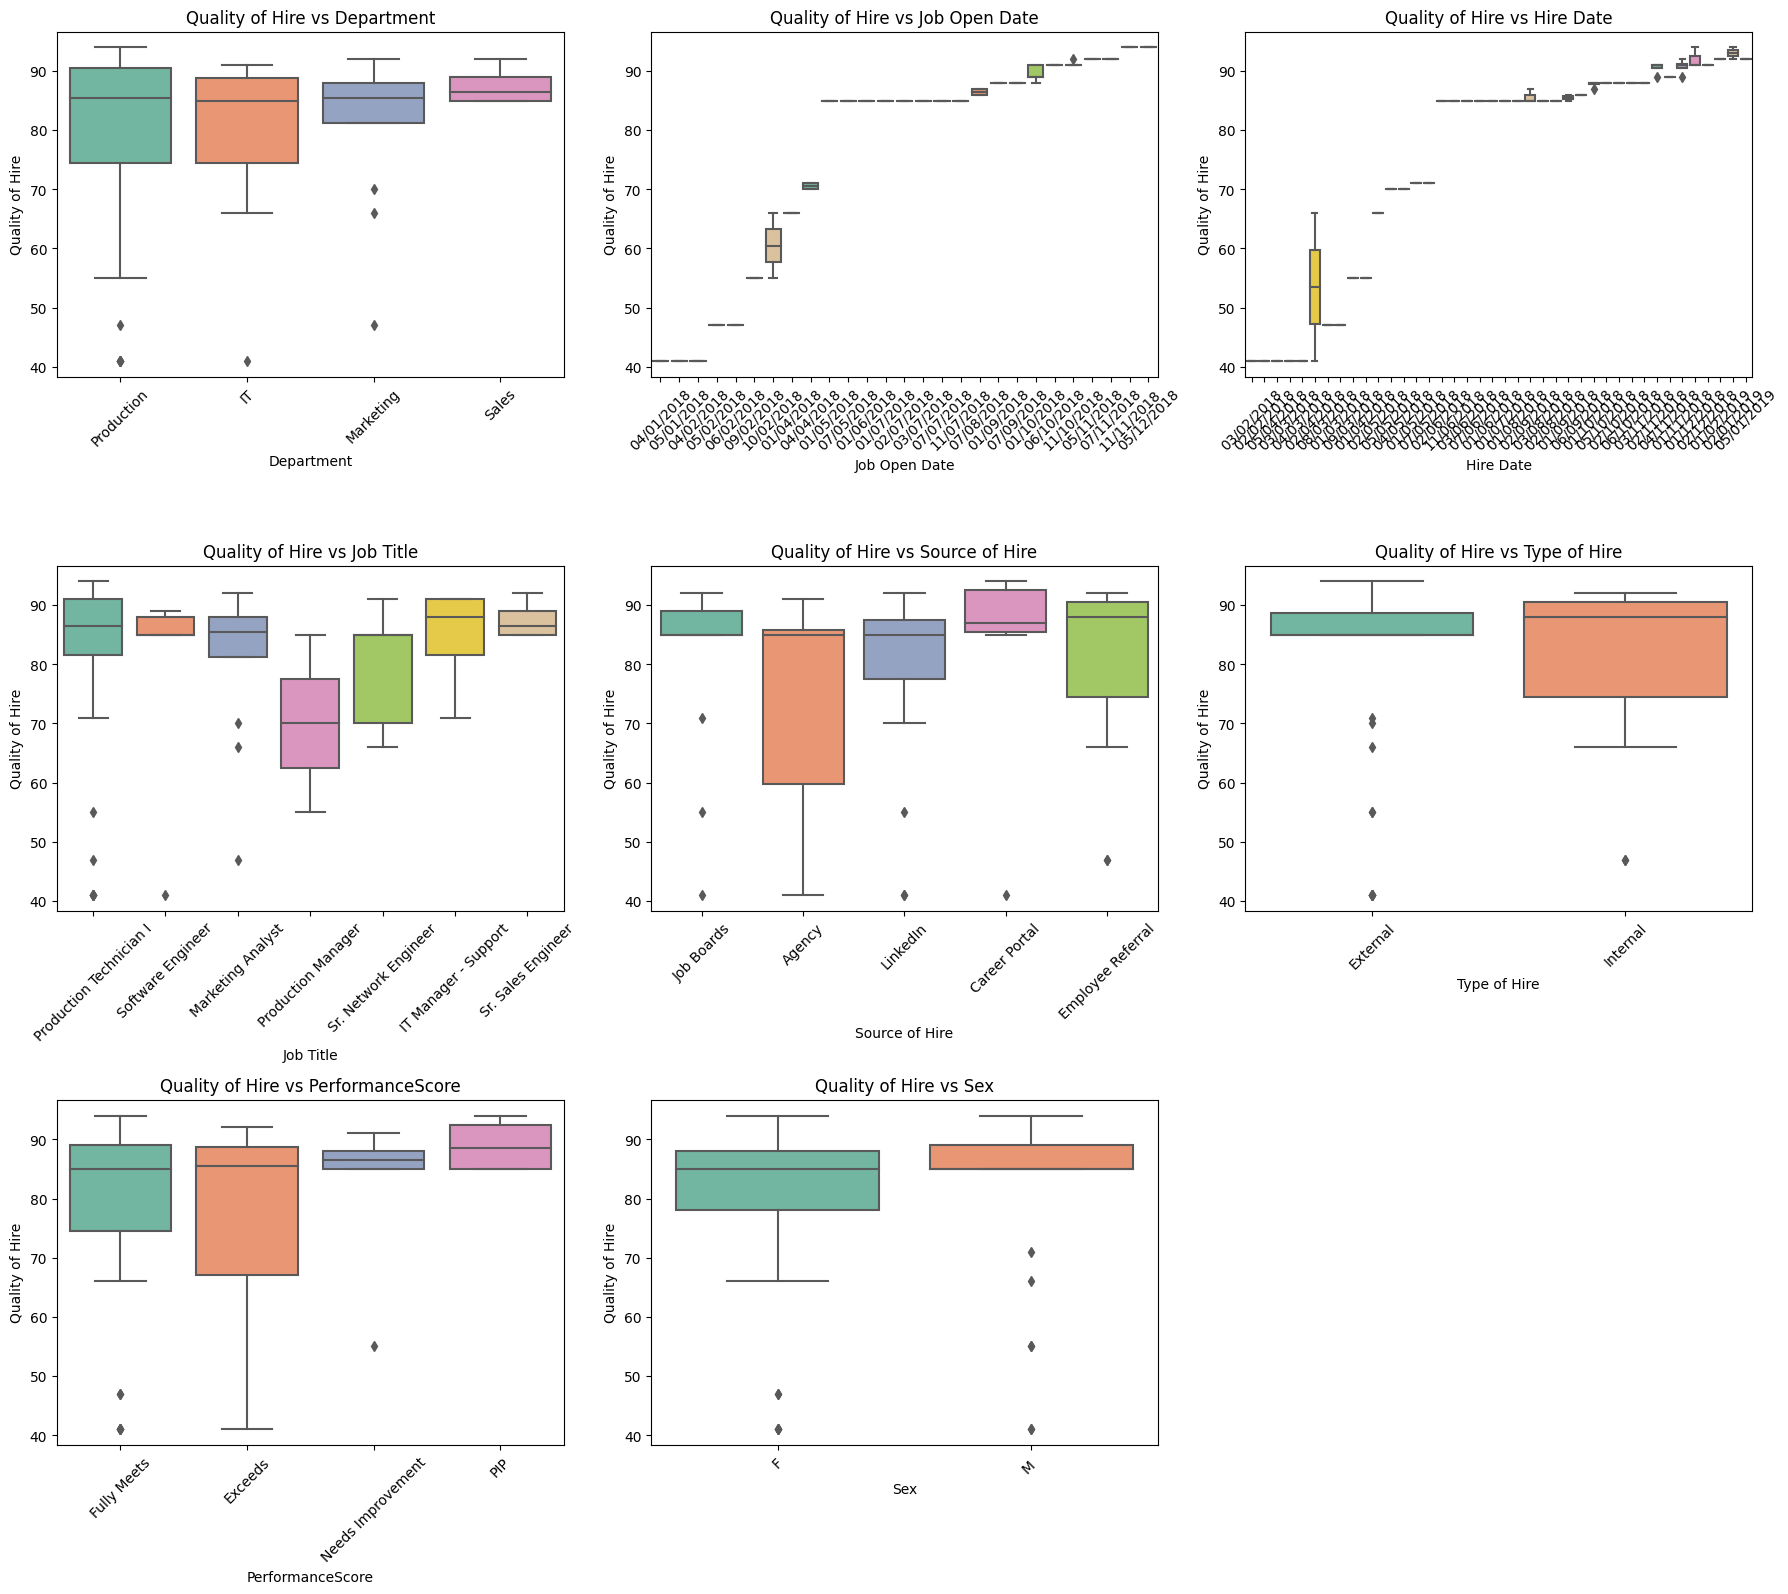

---------------------------------------------------------------------


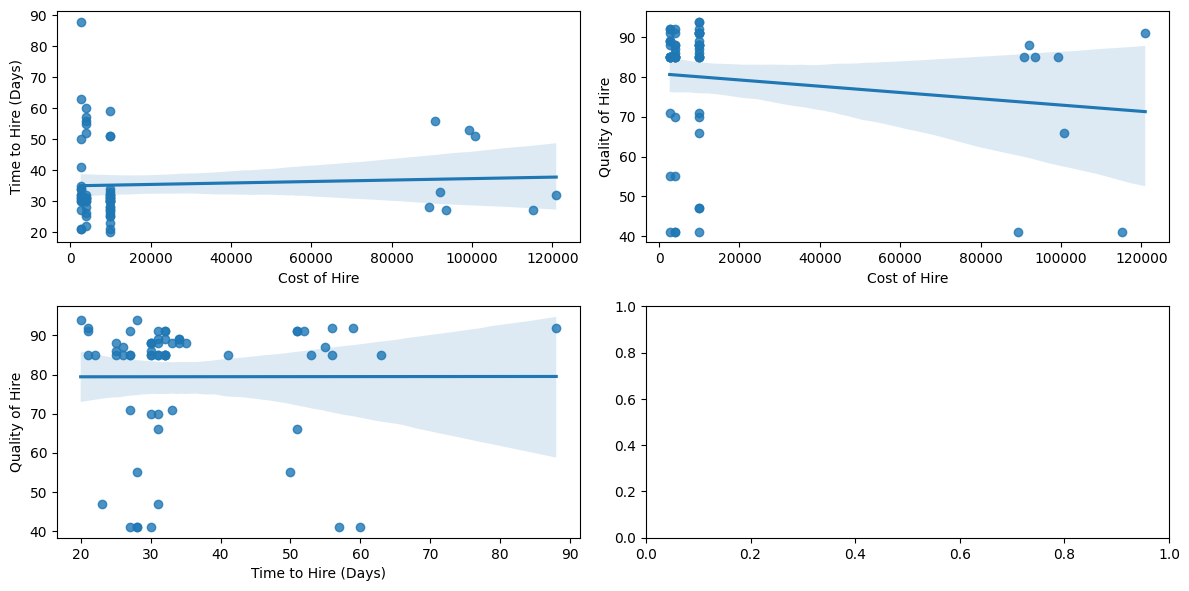

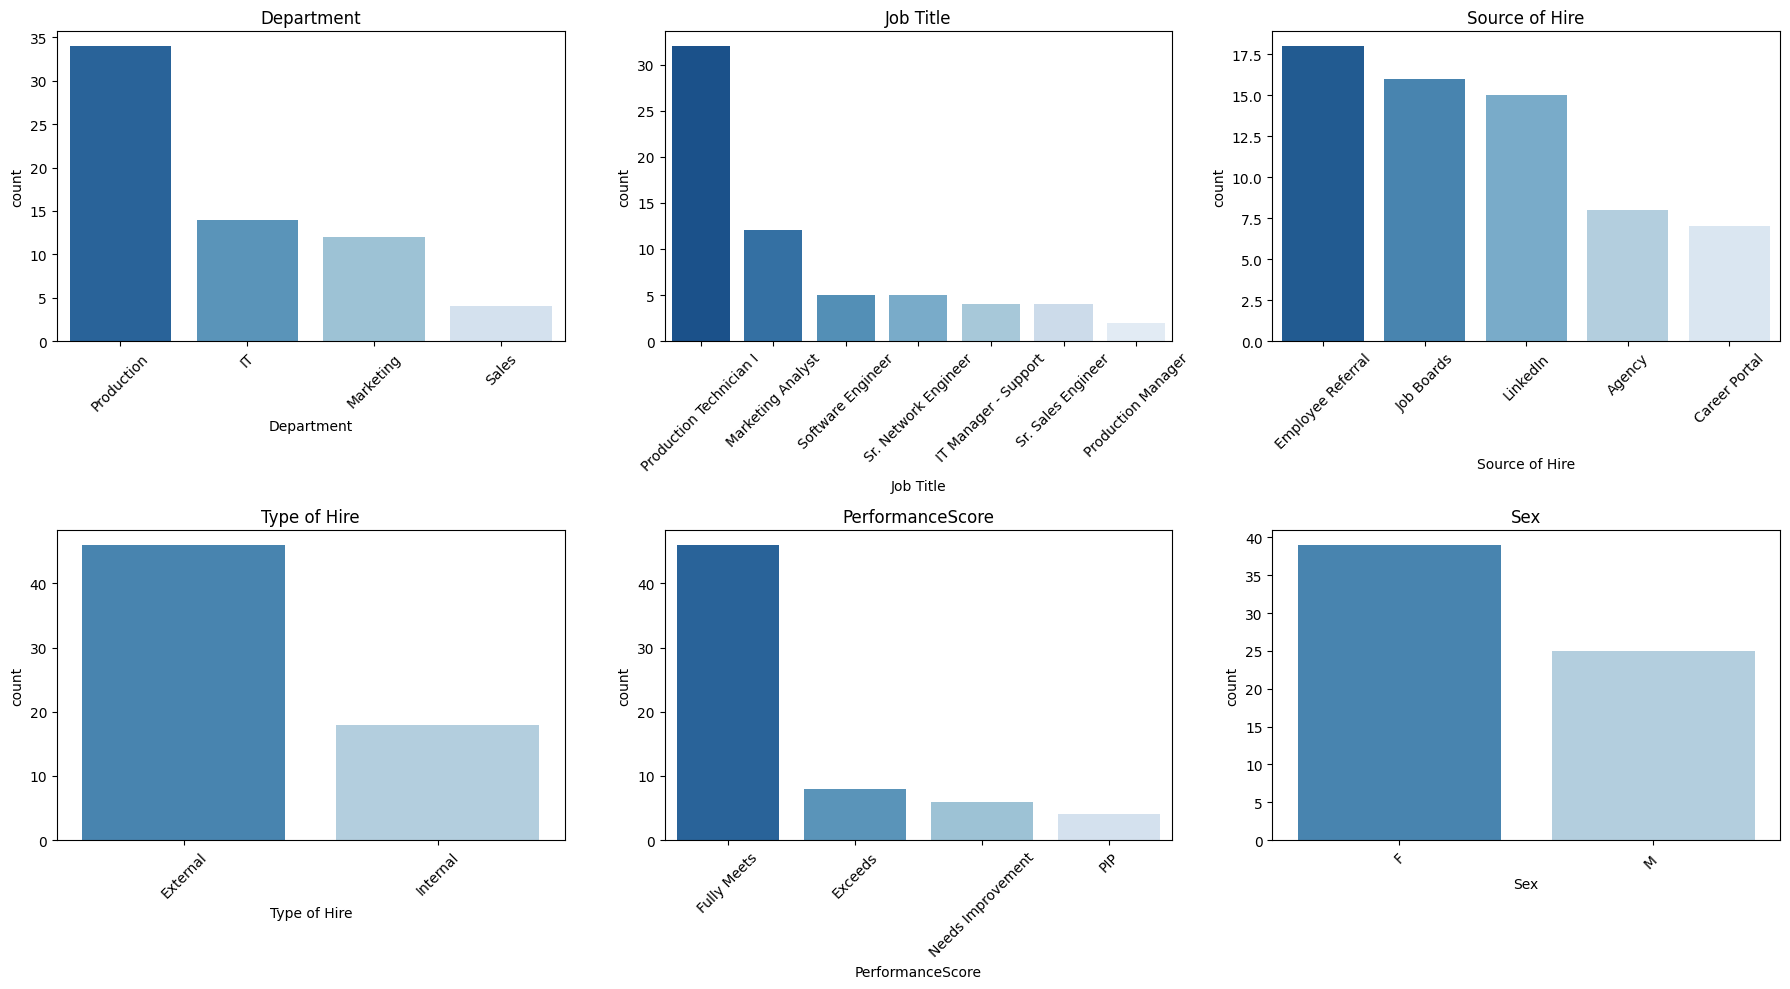

In [6]:
eda(data)

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


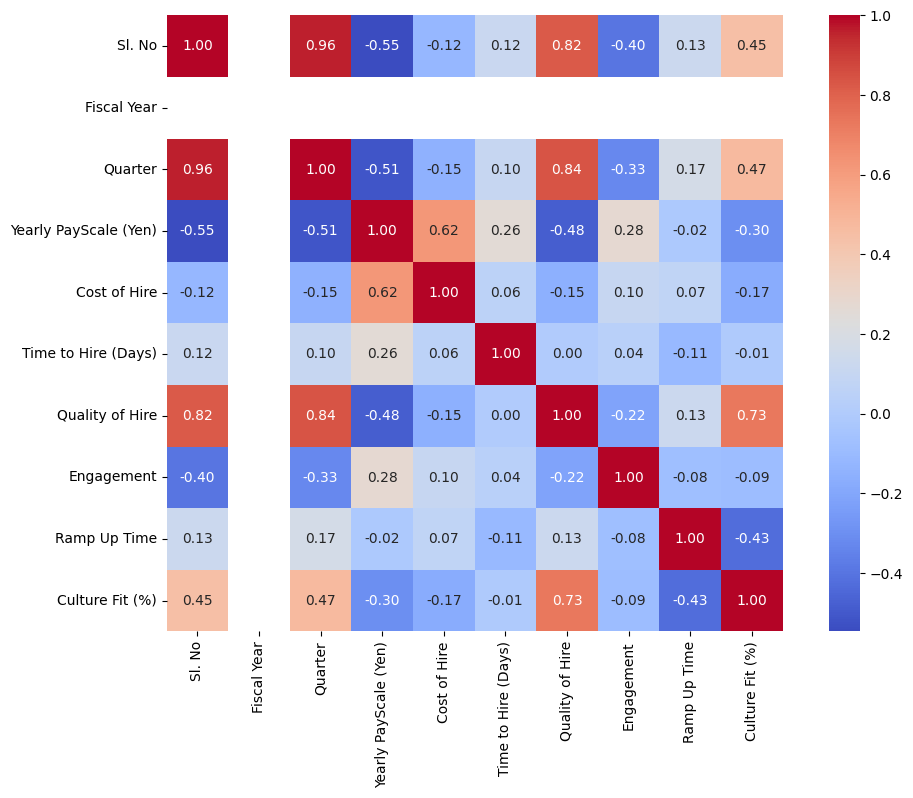

In [10]:
# Create a heatmap to visualize correlations between numeric variables  
plt.figure(figsize=(12, 8))  
sns.heatmap(data[data.select_dtypes(include=["float64", "int64"]).columns].corr(method='pearson'), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)  

plt.show()  # Show correlation heatmap  

* Quality of Hire & Quarter : possible relation


## Preprocessing

In [11]:
def preprocess(data):
    ## Make categorical cols into one hot
    df = pd.get_dummies(data[['Job Title', 'Source of Hire' ,'PerformanceScore']],drop_first=False)
     
    data_transform = pd.concat([data.drop(['Fiscal Year','Department', 'Job Title', 'Source of Hire','Type of Hire' ,'PerformanceScore','Sl. No'],axis=1),df],axis=1)

    ## Label encoder for nominal non-ordered variable
    le = LabelEncoder()

    data_transform['Sex'] = le.fit_transform(data_transform['Sex'])

    # Drop job open, hire date
    data_transform.drop(['Hire Date','Job Open Date'],axis=1,inplace=True)

    # Standardizing some columns 
    # Initialize the scaler  
    scaler = StandardScaler() 

    # Assuming df is your DataFrame  
    features_to_scale = ['Yearly PayScale (Yen)','Engagement', 'Ramp Up Time', 'Culture Fit (%)']   
    
    # Fit and transform the selected features  
    data_transform[features_to_scale] = scaler.fit_transform(data_transform[features_to_scale])  

    data_transform = data_transform.apply(lambda x : x.astype(float))

    ## Rename the columns
    data_transform['Yearly PayScale'] =  data_transform['Yearly PayScale (Yen)'] 
    data_transform.drop(['Yearly PayScale (Yen)'],axis=1,inplace=True)
    
    data_transform['Time to Hire'] =  data_transform['Time to Hire (Days)'] 
    data_transform.drop(['Time to Hire (Days)'],axis=1,inplace=True)

    data_transform['Culture Fit'] =  data_transform['Culture Fit (%)'] 
    data_transform.drop(['Culture Fit (%)'],axis=1,inplace=True)

    # Removing all spaces from column names  
    data_transform.columns = data_transform.columns.str.replace(" ", "", regex=True)
    data_transform.columns = data_transform.columns.str.replace(".", "_", regex=False) 
    data_transform.columns = data_transform.columns.str.replace("-", "_", regex=False) 

    return data_transform

In [12]:
df = preprocess(data)
df.head()

,Quarter,Sex,CostofHire,QualityofHire,Engagement,RampUpTime,JobTitle_ITManager_Support,JobTitle_MarketingAnalyst,JobTitle_ProductionManager,JobTitle_ProductionTechnicianI,JobTitle_SoftwareEngineer,JobTitle_Sr_NetworkEngineer,JobTitle_Sr_SalesEngineer,SourceofHire_Agency,SourceofHire_CareerPortal,SourceofHire_EmployeeReferral,SourceofHire_JobBoards,SourceofHire_LinkedIn,PerformanceScore_Exceeds,PerformanceScore_FullyMeets,PerformanceScore_NeedsImprovement,PerformanceScore_PIP,YearlyPayScale,TimetoHire,CultureFit
0,1.0,0.0,2625.0,41.0,-0.242366,0.798634,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.227128,30.0,-2.761887
1,1.0,0.0,89280.0,41.0,1.470837,0.798634,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.227128,28.0,-2.761887
2,1.0,0.0,4000.0,41.0,-1.122119,0.359523,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.818984,60.0,-2.683222
3,1.0,0.0,115200.0,41.0,-1.029513,0.359523,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.276640,27.0,-2.683222
4,1.0,1.0,10000.0,41.0,-0.751697,0.710812,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.818984,28.0,-2.447226


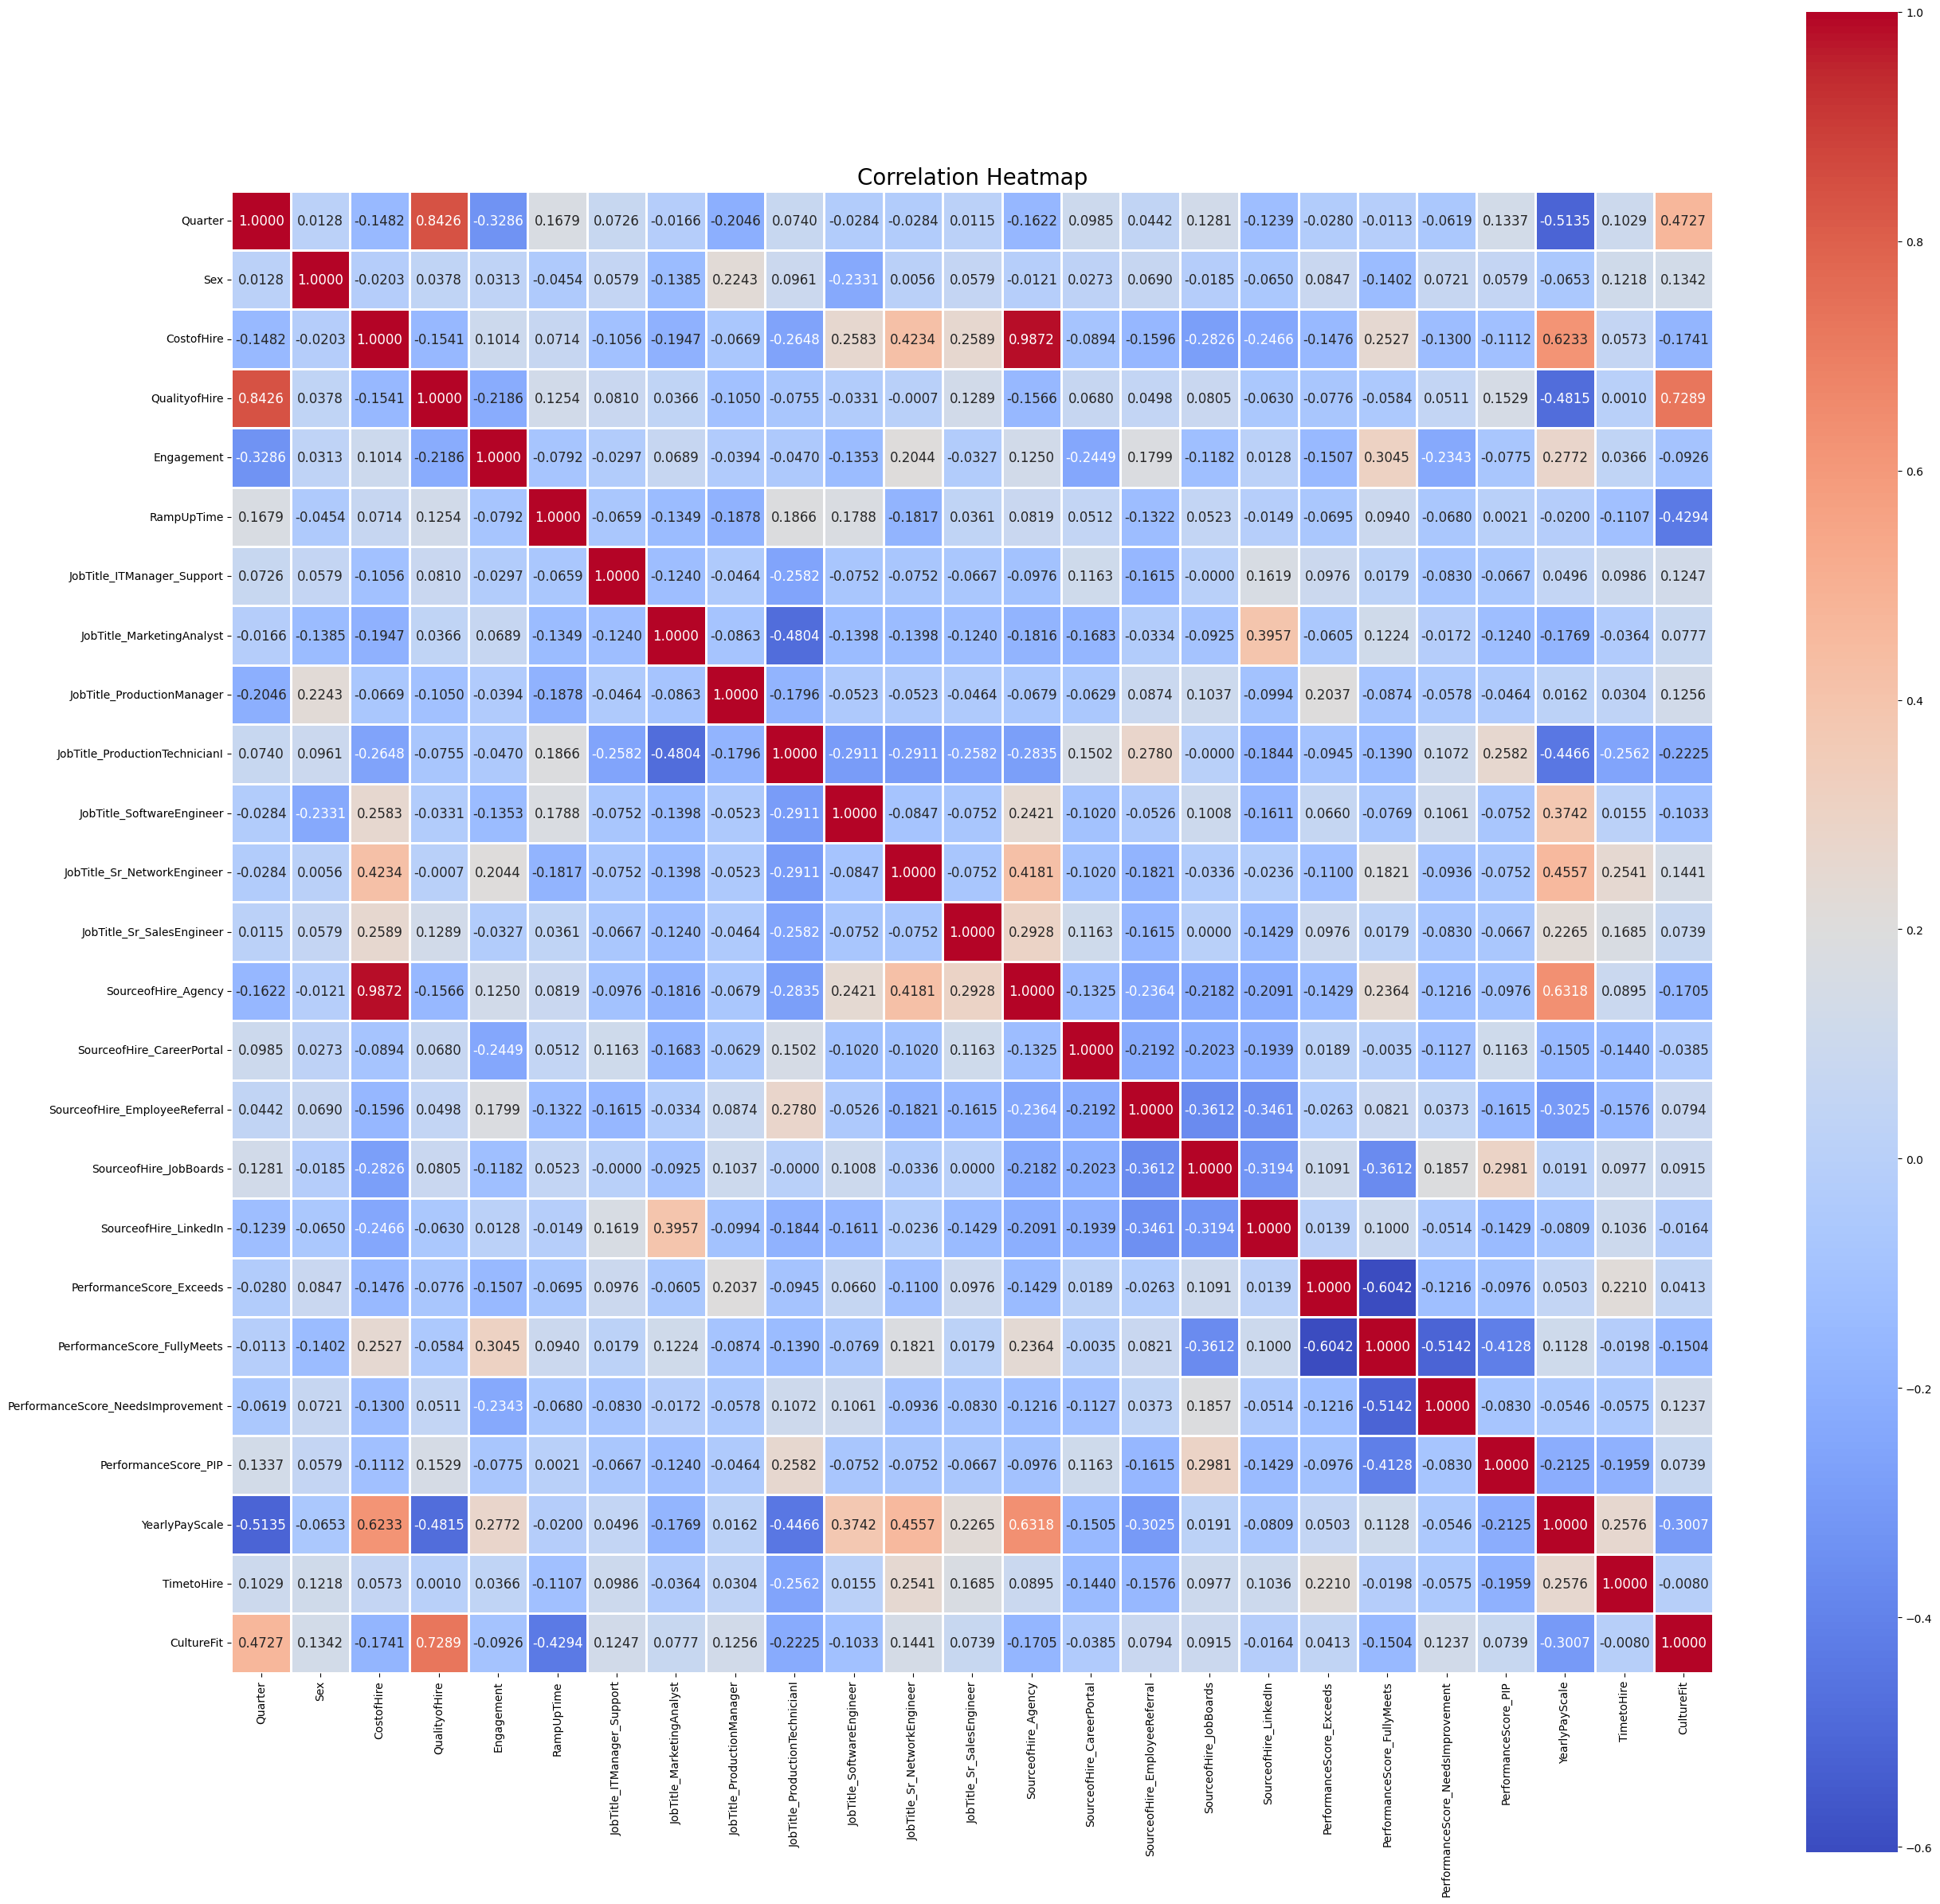

In [13]:
# Create a heatmap to visualize correlations between numeric variables after encoding

plt.figure(figsize=(30, 30))  
sns.heatmap(df.corr(), annot=True, fmt=".4f", cmap='coolwarm', square=True, cbar=True, annot_kws={"size": 12}, linewidths=0.8)  
plt.title('Correlation Heatmap', fontsize=20)  # Optional: Add a title with larger font size  
plt.show()  

#### RELATION POTENTIELLES
* Quality of Hire & Quarter
* Source of Hire Agency & CostOfHire
* Yearly Pay Scale & Source Of Hire Agency
* Quality Of Hire et Culture fit

In [14]:
# Split the data into training and testing sets  
train_data, test_data = train_test_split(df, test_size=0.09375, random_state=10)  

In [15]:
target = ['CostofHire','QualityofHire','TimetoHire']
X_train = train_data.drop(target,axis=1)

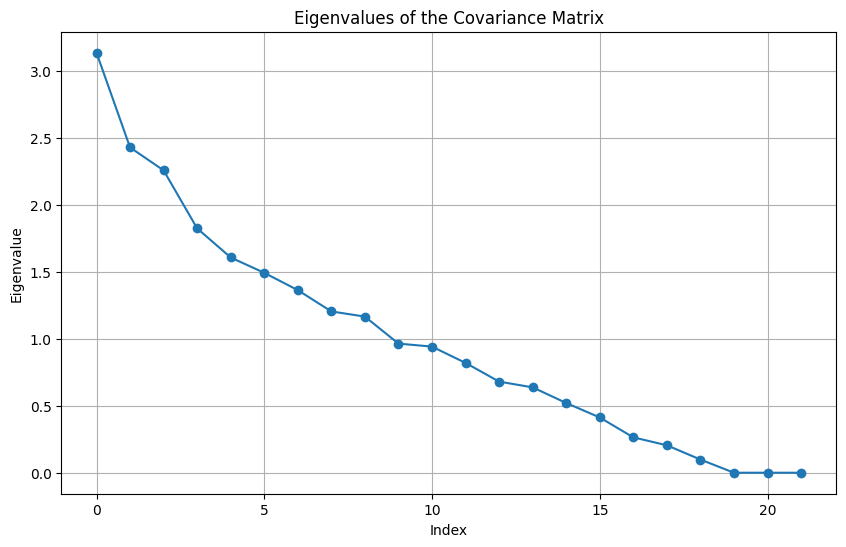

In [16]:
## Identify colinearity
correlation_matrix = np.corrcoef(X_train, rowvar=False)  
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)  

# Sort the eigenvalues in descending order  
sorted_eigenvalues = np.sort(eigenvalues)[::-1]  

# Plot  
plt.figure(figsize=(10, 6))  
plt.plot(sorted_eigenvalues, marker='o')  
plt.title('Eigenvalues of the Covariance Matrix')  
plt.xlabel('Index')  
plt.ylabel('Eigenvalue')  
plt.grid()  
plt.show()  

In [17]:
len(eigenvalues[eigenvalues<1])

13

## Modélisation

In [18]:
def fit_model(X, y_name, train):  
    """Fit a linear model and return the fitted model."""  
    cols = '+'.join(X.columns)  
    model_name = f"{y_name} ~ {cols}"  
    model = ols(model_name, train).fit()  
    return model  

In [19]:
def evaluation(model,test_data,y_name):
    # Make predictions on the test set  
    test_X = test_data.drop([y_name], axis=1)  
    predictions = model.predict(test_X)  
   
    # Calculate and print metrics (like MSE)  
    mse = mean_squared_error(test_data[y_name], predictions)  
    rmse = np.sqrt(mse)/(df[y_name].max()-df[y_name].min())
    print(f"\nRoot Mean Squared Error on test set: {rmse}")

In [20]:
def check_residuals(model,test_data,y_name):
    # Make predictions on the test set  
    test_X = test_data.drop([y_name], axis=1)  
    predictions = model.predict(test_X)  
    # Compute residuals
    residuals = test_data[y_name] - predictions

    # Test if residuals are normally distributed
    stat, p_value = shapiro(residuals)
    print(f"Shapiro-Wilk Test p-value: {p_value}")
    
    if p_value > 0.05:
        print("Residuals appear to be normally distributed.")
    else:
        print("Residuals are not normally distributed.")

In [21]:
def linear_multiple2(train, test, y_name, significance_level=0.05):  
    # Prepare the independent and dependent variables  
    X = train.drop(target, axis=1)  
    y = train[y_name]  
    
    # Initially include all columns in the model  
    cols = X.columns  
    print("Initial Columns:", cols)  
    
    # Fit the initial model
    model = fit_model(X, y_name, train)  
    
    # Print the initial summary
    print(model.summary())  
    
    # Evaluate on test set initially
    evaluation(model, test, y_name) 
    print('\n_____________________________________________')
    # Check residuals if normally ditributed
    check_residuals(model, test, y_name) 
    
    return model


In [22]:
quality_lr = linear_multiple2(train_data,test_data,'QualityofHire')

Initial Columns: Index(['Quarter', 'Sex', 'Engagement', 'RampUpTime',
       'JobTitle_ITManager_Support', 'JobTitle_MarketingAnalyst',
       'JobTitle_ProductionManager', 'JobTitle_ProductionTechnicianI',
       'JobTitle_SoftwareEngineer', 'JobTitle_Sr_NetworkEngineer',
       'JobTitle_Sr_SalesEngineer', 'SourceofHire_Agency',
       'SourceofHire_CareerPortal', 'SourceofHire_EmployeeReferral',
       'SourceofHire_JobBoards', 'SourceofHire_LinkedIn',
       'PerformanceScore_Exceeds', 'PerformanceScore_FullyMeets',
       'PerformanceScore_NeedsImprovement', 'PerformanceScore_PIP',
       'YearlyPayScale', 'CultureFit'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:          QualityofHire   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     26.30
Date:                Mon, 03

In [23]:
print(quality_lr.params)

Intercept                            41.280275
Quarter                               7.063170
Sex                                  -1.765160
Engagement                            1.543723
RampUpTime                            5.210357
JobTitle_ITManager_Support            5.044175
JobTitle_MarketingAnalyst             3.882458
JobTitle_ProductionManager            5.341841
JobTitle_ProductionTechnicianI       -0.085797
JobTitle_SoftwareEngineer             7.405085
JobTitle_Sr_NetworkEngineer           6.795034
JobTitle_Sr_SalesEngineer            12.897479
SourceofHire_Agency                   8.391004
SourceofHire_CareerPortal            10.438285
SourceofHire_EmployeeReferral         8.953125
SourceofHire_JobBoards                5.745765
SourceofHire_LinkedIn                 7.752096
PerformanceScore_Exceeds              5.504634
PerformanceScore_FullyMeets           8.417807
PerformanceScore_NeedsImprovement    13.213457
PerformanceScore_PIP                 14.144378
YearlyPayScal

In [24]:
cost_lr = linear_multiple2(train_data,test_data,'CostofHire')  

Initial Columns: Index(['Quarter', 'Sex', 'Engagement', 'RampUpTime',
       'JobTitle_ITManager_Support', 'JobTitle_MarketingAnalyst',
       'JobTitle_ProductionManager', 'JobTitle_ProductionTechnicianI',
       'JobTitle_SoftwareEngineer', 'JobTitle_Sr_NetworkEngineer',
       'JobTitle_Sr_SalesEngineer', 'SourceofHire_Agency',
       'SourceofHire_CareerPortal', 'SourceofHire_EmployeeReferral',
       'SourceofHire_JobBoards', 'SourceofHire_LinkedIn',
       'PerformanceScore_Exceeds', 'PerformanceScore_FullyMeets',
       'PerformanceScore_NeedsImprovement', 'PerformanceScore_PIP',
       'YearlyPayScale', 'CultureFit'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:             CostofHire   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     229.5
Date:                Mon, 03

In [25]:
print(cost_lr.params)

Intercept                            11432.675550
Quarter                               1878.515536
Sex                                   -414.416472
Engagement                           -1166.783152
RampUpTime                             129.755611
JobTitle_ITManager_Support            1540.499625
JobTitle_MarketingAnalyst             4084.293779
JobTitle_ProductionManager            4408.509204
JobTitle_ProductionTechnicianI        4578.978386
JobTitle_SoftwareEngineer            -1889.912773
JobTitle_Sr_NetworkEngineer           2979.333419
JobTitle_Sr_SalesEngineer            -4269.026090
SourceofHire_Agency                  73304.317765
SourceofHire_CareerPortal           -13017.683762
SourceofHire_EmployeeReferral       -11035.914726
SourceofHire_JobBoards              -20297.818785
SourceofHire_LinkedIn               -17520.224942
PerformanceScore_Exceeds              2913.928667
PerformanceScore_FullyMeets           2472.563914
PerformanceScore_NeedsImprovement     2274.392449


In [26]:
time_lr = linear_multiple2(train_data,test_data,'TimetoHire')

Initial Columns: Index(['Quarter', 'Sex', 'Engagement', 'RampUpTime',
       'JobTitle_ITManager_Support', 'JobTitle_MarketingAnalyst',
       'JobTitle_ProductionManager', 'JobTitle_ProductionTechnicianI',
       'JobTitle_SoftwareEngineer', 'JobTitle_Sr_NetworkEngineer',
       'JobTitle_Sr_SalesEngineer', 'SourceofHire_Agency',
       'SourceofHire_CareerPortal', 'SourceofHire_EmployeeReferral',
       'SourceofHire_JobBoards', 'SourceofHire_LinkedIn',
       'PerformanceScore_Exceeds', 'PerformanceScore_FullyMeets',
       'PerformanceScore_NeedsImprovement', 'PerformanceScore_PIP',
       'YearlyPayScale', 'CultureFit'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:             TimetoHire   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     1.490
Date:                Mon, 03

In [27]:
print(time_lr.params)

Intercept                            12.324424
Quarter                               5.821859
Sex                                   4.380935
Engagement                            0.666681
RampUpTime                           -3.984832
JobTitle_ITManager_Support           -0.272751
JobTitle_MarketingAnalyst            -4.496661
JobTitle_ProductionManager            1.499493
JobTitle_ProductionTechnicianI       -6.638781
JobTitle_SoftwareEngineer            -5.191874
JobTitle_Sr_NetworkEngineer          12.906431
JobTitle_Sr_SalesEngineer            14.518567
SourceofHire_Agency                  -7.784901
SourceofHire_CareerPortal             0.992055
SourceofHire_EmployeeReferral         3.862289
SourceofHire_JobBoards                7.424270
SourceofHire_LinkedIn                 7.830711
PerformanceScore_Exceeds              6.650075
PerformanceScore_FullyMeets           3.369889
PerformanceScore_NeedsImprovement     5.963997
PerformanceScore_PIP                 -3.659537
YearlyPayScal

## RIDGE

In [28]:
def ridge_reg(train,test,y_name,alphas):
    # **Ridge Regression**
    # Prepare the independent and dependent variables  
    X = train.drop(['QualityofHire','TimetoHire','CostofHire'], axis=1)  
    y = train[y_name] 
    
    ridge_cv_model = RidgeCV(alphas=alphas, store_cv_values=True)  

    # Adjust RidgeCV 
    ridge_cv_model.fit(X, y)

    ridge_cv_coeffs = ridge_cv_model.coef_
    column_names = X.columns

    positive_coeffs = []
    negative_coeffs = []
    coefficients={}
    for i, coeff in enumerate(ridge_cv_coeffs):
        if coeff >= 0:
            positive_coeffs.append((column_names[i], coeff))
        else:
            negative_coeffs.append((column_names[i], coeff))
        
    
    print("\nCoefficients positifs:")
    for name, coeff in positive_coeffs:
        print(f"  {name}: {coeff:.4f}")
    
    print("\nCoefficients négatifs:")
    for name, coeff in negative_coeffs:
        print(f"  {name}: {coeff:.4f}")
    
    labels = ['QualityofHire', 'TimetoHire', 'CostofHire']
    labels.remove(y_name)
    print(f"\nRidge avec Alpha:{ridge_cv_model.alpha_}")
    # Evaluation on test  
    evaluation(ridge_cv_model, test.drop(labels, axis=1), y_name)

    return ridge_cv_model


In [29]:
quality = ridge_reg(train_data,test_data,'QualityofHire',np.linspace(0.001,4,1000))


Coefficients positifs:
  Quarter: 7.3715
  Engagement: 0.9181
  RampUpTime: 4.4269
  JobTitle_SoftwareEngineer: 0.8937
  JobTitle_Sr_NetworkEngineer: 0.0721
  JobTitle_Sr_SalesEngineer: 2.5459
  SourceofHire_Agency: 0.8945
  SourceofHire_CareerPortal: 0.6520
  SourceofHire_EmployeeReferral: 0.2967
  PerformanceScore_NeedsImprovement: 1.5126
  PerformanceScore_PIP: 1.8532
  CultureFit: 8.4238

Coefficients négatifs:
  Sex: -1.0850
  JobTitle_ITManager_Support: -0.0671
  JobTitle_MarketingAnalyst: -0.1564
  JobTitle_ProductionManager: -0.3256
  JobTitle_ProductionTechnicianI: -2.9626
  SourceofHire_JobBoards: -1.5263
  SourceofHire_LinkedIn: -0.3169
  PerformanceScore_Exceeds: -2.3057
  PerformanceScore_FullyMeets: -1.0602
  YearlyPayScale: -1.8803

Ridge avec Alpha:3.5076306306306306

Root Mean Squared Error on test set: 0.0609714254329331


In [30]:
cost = ridge_reg(train_data,test_data,'CostofHire',np.linspace(0.001,4,1000))


Coefficients positifs:
  Quarter: 1856.8888
  RampUpTime: 145.6125
  JobTitle_MarketingAnalyst: 2366.9893
  JobTitle_ProductionManager: 2656.5800
  JobTitle_ProductionTechnicianI: 2845.1732
  JobTitle_Sr_NetworkEngineer: 1540.4018
  SourceofHire_Agency: 70586.6647
  PerformanceScore_Exceeds: 4.8670
  PerformanceScore_PIP: 947.4855
  YearlyPayScale: 4048.4877
  CultureFit: 783.1120

Coefficients négatifs:
  Sex: -407.9462
  Engagement: -1181.7769
  JobTitle_ITManager_Support: -178.8183
  JobTitle_SoftwareEngineer: -3608.9905
  JobTitle_Sr_SalesEngineer: -5621.3356
  SourceofHire_CareerPortal: -15168.7928
  SourceofHire_EmployeeReferral: -13190.4235
  SourceofHire_JobBoards: -22507.9556
  SourceofHire_LinkedIn: -19719.4928
  PerformanceScore_FullyMeets: -365.9769
  PerformanceScore_NeedsImprovement: -586.3755

Ridge avec Alpha:0.017012012012012013

Root Mean Squared Error on test set: 0.07940816897488022


In [31]:
time = ridge_reg(train_data,test_data,'TimetoHire',np.linspace(0.001,10,1000))


Coefficients positifs:
  Quarter: 4.0187
  Sex: 2.7607
  Engagement: 0.5545
  JobTitle_ITManager_Support: 0.4364
  JobTitle_ProductionManager: 0.3760
  JobTitle_Sr_NetworkEngineer: 1.8722
  JobTitle_Sr_SalesEngineer: 1.8269
  SourceofHire_JobBoards: 1.7747
  SourceofHire_LinkedIn: 1.5160
  PerformanceScore_Exceeds: 1.7679
  PerformanceScore_FullyMeets: 0.2325
  PerformanceScore_NeedsImprovement: 0.1524
  YearlyPayScale: 2.9619

Coefficients négatifs:
  RampUpTime: -2.5086
  JobTitle_MarketingAnalyst: -0.7163
  JobTitle_ProductionTechnicianI: -2.8293
  JobTitle_SoftwareEngineer: -0.9659
  SourceofHire_Agency: -1.1334
  SourceofHire_CareerPortal: -1.3188
  SourceofHire_EmployeeReferral: -0.8384
  PerformanceScore_PIP: -2.1529
  CultureFit: -2.0066

Ridge avec Alpha:10.0

Root Mean Squared Error on test set: 0.19431775254158568


In [32]:

diff = abs(quality_lr.params.values[1:] - quality.coef_)
diff_df = pd.DataFrame({'Variables' : X_train.columns,'|Coeff OLS-Ridge|': diff})
print(diff_df)

                            Variables  |Coeff OLS-Ridge|
0                             Quarter           0.308328
1                                 Sex           0.680179
2                          Engagement           0.625597
3                          RampUpTime           0.783441
4          JobTitle_ITManager_Support           5.111264
5           JobTitle_MarketingAnalyst           4.038902
6          JobTitle_ProductionManager           5.667399
7      JobTitle_ProductionTechnicianI           2.876842
8           JobTitle_SoftwareEngineer           6.511368
9         JobTitle_Sr_NetworkEngineer           6.722922
10          JobTitle_Sr_SalesEngineer          10.351578
11                SourceofHire_Agency           7.496491
12          SourceofHire_CareerPortal           9.786322
13      SourceofHire_EmployeeReferral           8.656434
14             SourceofHire_JobBoards           7.272034
15              SourceofHire_LinkedIn           8.068994
16           PerformanceScore_E

In [33]:
## ANOVA  2 way to check which variables are signifient 
## QUALITY
anova_results = anova_lm(quality_lr, typ=2)
quality_results = anova_results[anova_results['PR(>F)'] < 0.05]  
print(quality_results)

                                        sum_sq   df          F        PR(>F)
Quarter                             923.165291  1.0  40.035882  2.025945e-07
RampUpTime                          885.186399  1.0  38.388811  3.067231e-07
JobTitle_ITManager_Support           99.633363  1.0   4.320905  4.444949e-02
JobTitle_SoftwareEngineer           133.378914  1.0   5.784384  2.114596e-02
JobTitle_Sr_NetworkEngineer         111.070237  1.0   4.816900  3.436417e-02
JobTitle_Sr_SalesEngineer           330.614136  1.0  14.338092  5.290123e-04
SourceofHire_Agency                 240.333452  1.0  10.422794  2.566358e-03
SourceofHire_CareerPortal           589.933530  1.0  25.584269  1.107181e-05
SourceofHire_EmployeeReferral       664.837583  1.0  28.832712  4.163944e-06
SourceofHire_JobBoards              382.448058  1.0  16.586028  2.275325e-04
SourceofHire_LinkedIn               636.728439  1.0  27.613673  5.973638e-06
PerformanceScore_Exceeds            211.891619  1.0   9.189327  4.367142e-03

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [34]:
quality_ = ridge_reg(train_data[quality_results.index.to_list() + target],test_data[quality_results.index.to_list() + target],'QualityofHire',np.linspace(0.001,3,1000))


Coefficients positifs:
  Quarter: 7.7730
  RampUpTime: 4.3589
  JobTitle_ITManager_Support: 0.0878
  JobTitle_SoftwareEngineer: 0.8960
  JobTitle_Sr_SalesEngineer: 2.3088
  SourceofHire_Agency: 0.2504
  SourceofHire_CareerPortal: 0.1092
  SourceofHire_EmployeeReferral: 0.5806
  SourceofHire_LinkedIn: 0.6567
  PerformanceScore_NeedsImprovement: 1.0086
  PerformanceScore_PIP: 1.9674
  CultureFit: 9.0780

Coefficients négatifs:
  JobTitle_Sr_NetworkEngineer: -0.4995
  SourceofHire_JobBoards: -1.5969
  PerformanceScore_Exceeds: -2.4018
  PerformanceScore_FullyMeets: -0.5741

Ridge avec Alpha:3.0

Root Mean Squared Error on test set: 0.055086942139643054


In [35]:
## COST
anova_results = anova_lm(cost_lr, typ=2)
cost_results = anova_results[anova_results['PR(>F)'] < 0.05]  
print(cost_results)

                                      sum_sq   df            F        PR(>F)
Quarter                         6.529949e+07  1.0     6.156859  1.763028e-02
Engagement                      4.375258e+07  1.0     4.125278  4.928545e-02
JobTitle_MarketingAnalyst       9.525654e+07  1.0     8.981405  4.785425e-03
JobTitle_ProductionTechnicianI  1.245071e+08  1.0    11.739333  1.483271e-03
SourceofHire_Agency             1.834195e+10  1.0  1729.398142  2.692822e-33
SourceofHire_CareerPortal       9.175129e+08  1.0    86.509073  2.458550e-11
SourceofHire_EmployeeReferral   1.010143e+09  1.0    95.242863  6.691385e-12
SourceofHire_JobBoards          4.772824e+09  1.0   450.012817  1.152331e-22
SourceofHire_LinkedIn           3.252335e+09  1.0   306.651280  8.687474e-20
PerformanceScore_Exceeds        5.937652e+07  1.0     5.598404  2.317909e-02
PerformanceScore_FullyMeets     7.265973e+07  1.0     6.850831  1.264904e-02
PerformanceScore_PIP            5.998845e+07  1.0     5.656101  2.252659e-02

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [36]:
cost_ = ridge_reg(train_data[cost_results.index.to_list() + target],test_data[cost_results.index.to_list() + target],'CostofHire',np.linspace(0.001,4,1000))


Coefficients positifs:
  Quarter: 1538.7746
  JobTitle_MarketingAnalyst: 1913.2173
  JobTitle_ProductionTechnicianI: 1931.0281
  SourceofHire_Agency: 70576.7310
  PerformanceScore_Exceeds: 139.3695
  PerformanceScore_FullyMeets: 377.0061
  PerformanceScore_PIP: 1828.3652
  YearlyPayScale: 3065.4992

Coefficients négatifs:
  Engagement: -973.7331
  SourceofHire_CareerPortal: -15094.1544
  SourceofHire_EmployeeReferral: -13217.4849
  SourceofHire_JobBoards: -22581.5092
  SourceofHire_LinkedIn: -19683.5824

Ridge avec Alpha:0.001

Root Mean Squared Error on test set: 0.05775658116884017


In [37]:
## TIME 
anova_results = anova_lm(time_lr, typ=2)
time_results = anova_results[anova_results['PR(>F)'] < 0.05]  
print(time_results)

                            sum_sq   df         F    PR(>F)
Quarter                 627.196458  1.0  4.326364  0.044322
SourceofHire_JobBoards  638.534175  1.0  4.404570  0.042542
SourceofHire_LinkedIn   649.708182  1.0  4.481648  0.040865
CultureFit              653.736078  1.0  4.509432  0.040278


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [38]:
time_ = ridge_reg(train_data[time_results.index.to_list() + target],test_data[time_results.index.to_list() + target],'TimetoHire',np.linspace(0.00001,20,1000))


Coefficients positifs:
  Quarter: 1.2108
  SourceofHire_JobBoards: 1.2935
  SourceofHire_LinkedIn: 0.8220
  CultureFit: 0.1340

Coefficients négatifs:

Ridge avec Alpha:20.0

Root Mean Squared Error on test set: 0.20356665942689783
